In [1]:
#IMporting necessary packages
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import chart_studio.plotly as py
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import ipywidgets as widgets
from IPython.display import display, clear_output

In [2]:
#!jupyter nbextension enable --py widgetsnbextension --sys-prefix
#!jupyter serverextension enable voila --sys-prefix

In [3]:
name=widgets.Text(placeholder='Please enter your name here:')

In [4]:
res=widgets.Box(
    [
        widgets.Label(value='What is your sentiment towards the COVID-19 Pandemic?'),
        widgets.RadioButtons(
            options=[
                'Neutral',
                'Positive',
                'Negative'
            ],
            layout={'width': 'max-content'}
        )
    ]
)

In [5]:
button_send=widgets.Button(description='Submit', tooltip='Submit',style={'description_width': 'initial'})
output=widgets.Output()

def on_button_clicked(event):
    with output:
        clear_output()
        print("Successfully submitted your response.")
        print(f"Hi {name.value}")
        
button_send.on_click(on_button_clicked)
vbox_result=widgets.VBox([button_send,output])

In [6]:
text_0=widgets.HTML(value="<h1>Welcome to COVID-19 Emotion Dashboard</h1>")
text_1=widgets.HTML(value="<h4>Enter your name</h4>")
vbox_text=widgets.VBox([text_0,text_1,name,res,vbox_result])

In [7]:
page=widgets.HBox([vbox_text])
display(page)

In [8]:
#Importing dataset
df=pd.read_csv('C:/Users/Prijita/Desktop/covid-19-tweets/covid19_tweets.csv')

# Analyse the Emotion of People during COVID-19

In [11]:
# Load Text Cleaning Package
import neattext.functions as nfx

In [12]:
df['extracted_hashtags'] = df['text'].apply(nfx.extract_hashtags)

In [13]:
# Cleaning Text
df['clean_tweet'] = df['text'].apply(nfx.remove_hashtags)

In [14]:
#Remove @mentions
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: nfx.remove_userhandles(x))

In [15]:
# Cleaning Text: Multiple WhiteSpaces
df['clean_tweet'] = df['clean_tweet'].apply(nfx.remove_multiple_spaces)

In [16]:
# Cleaning Text : Remove urls
df['clean_tweet'] = df['clean_tweet'].apply(nfx.remove_urls)

In [17]:
# Cleaning Text: Punctuations
df['clean_tweet'] = df['clean_tweet'].apply(nfx.remove_puncts)

In [18]:
#Calculate the Jaccard similarity coefficient between the text and the clean_tweets. It measures the similarity between the sample sets and is ratio of intersection over union
#Here we are trying to predict if the clean_tweet is a subset of text.
#We got to know from our research that neutral tweets have a jaccard similarity of 97 percent between text and selected_text
#Since clean_tweet starts from between the words and thus clean_tweet dont always make sense and since we do not know whether the output of text contain these descrepancies or not ,we are not sure that preprocessing and removing punctuations would be a good idea or not
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [19]:
results_jaccard=[]

for ind,row in df.iterrows():
    sentence1 = row.text
    sentence2 = row.clean_tweet

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [20]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","clean_tweet","jaccard_score"])
df=df.merge(jaccard,how='outer')

In [21]:
#Calculates the number of words in text and clean_tweets and their difference
df['Num_words_CT']=df['clean_tweet'].apply(lambda x: len(str(x).split()))
df['Num_word_text']=df['text'].apply(lambda x: len(str(x).split()))
df['Diff_in_words']=df['Num_word_text']-df['Num_words_CT']

### The below plot gives a KDE plot for Number of words in the clean tweet and the real tweet and its visualization

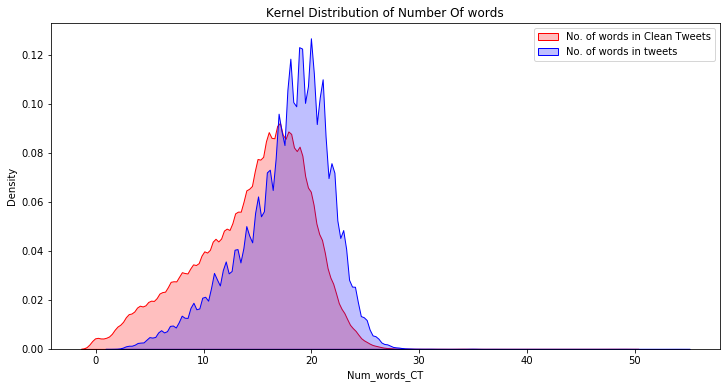

In [22]:
#A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset
plt.figure(figsize=(12,6))
p1=sns.kdeplot(df['Num_words_CT'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(df['Num_word_text'], shade=True, color="b")
plt.legend(labels=['No. of words in Clean Tweets','No. of words in tweets']);

In [23]:
#Clean the text
#The sub() function replaces the matches with the text of your choice
def clean_text(text):
    text = str(text).lower() #Lowercase of the text
    text = re.sub('\[.*?\]', '', text) #Replace any character with zero or one occurance along with special sequence with the single white space
    text = re.sub('https?://\S+|www\.\S+', '', text) #Replace the urls with the single white space
    text = re.sub('<.*?>+', '', text) #HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #Replace punctuations with single white space
    text = re.sub('\n', '', text) #Replace newline with single white space
    text = re.sub('\w*\d\w*', '', text) #Replace texts with digits with single white space
    return text

In [24]:
df['text'] = df['text'].apply(lambda x:clean_text(x))
df['clean_tweet'] = df['clean_tweet'].apply(lambda x:clean_text(x))

In [25]:
#Remove emoticons,map and transport symbols and pictures
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [26]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x:deEmojify(x))

In [27]:
#Remove stopwords
df['temp_list'] = df['clean_tweet'].apply(lambda x:str(x).split())
from nltk.corpus import stopwords
def remove_stopword(x):
    return [y for y in x if y not in STOPWORDS]
df['temp_list'] = df['temp_list'].apply(lambda x:remove_stopword(x))

In [28]:
df['temp_list1'] = df['text'].apply(lambda x:str(x).split()) #Text converted into list of words
df['temp_list1'] = df['temp_list1'].apply(lambda x:remove_stopword(x))

In [29]:
from textblob import TextBlob

In [30]:
#Assigning texts sentiments according to polarity scores
#Calculate the polarity and subjectivity
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity
    sentiment_subjectivity = blob.sentiment.subjectivity
    if sentiment_polarity > 0:
        sentiment_label = 'Positive'
    elif sentiment_polarity < 0:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    result = {'polarity':sentiment_polarity,
              'subjectivity':sentiment_subjectivity,
              'sentiment':sentiment_label}
    return result

In [31]:
#Clean tweet of row 1
ex1 = df['clean_tweet'].iloc[0]

In [32]:
df['sentiment_results'] = df['clean_tweet'].apply(get_sentiment)

In [33]:
df = df.join(pd.json_normalize(df['sentiment_results']))

## Now there are plots for understanding the numerical concepts of the sentiments

### The below dataframe gives most 20 common words after removing stopwords

In [34]:
#Most common words after removing the stopwords in clean_tweet
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,new,14491
2,amp,11958
3,people,8955
4,will,8491
5,deaths,7086
6,pandemic,7056
7,us,6948
8,…,6231
9,now,6133
10,coronavirus,5441


### The below plot is a tree map to show the most common words in the text

In [35]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

### The below dataframe gives the top most 25 common words in the text

In [36]:
#Most common words in text
top = Counter([item for sublist in df['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,new,14401
2,coronavirus,13952
3,amp,11931
4,…,11544
5,people,8868
6,will,8463
7,pandemic,8175
8,us,7189
9,deaths,6874
10,now,5933


### Bar plot for representing the top most common words

In [37]:
fig = px.bar(temp, x="count", y="Common_words", title='Common Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [38]:
Positive_sent = df[df['sentiment']=='Positive']
Negative_sent = df[df['sentiment']=='Negative']
Neutral_sent = df[df['sentiment']=='Neutral']

### Top most positive words

In [39]:
#Common words in positive tweets
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,new,13515
1,cases,11843
2,amp,5324
3,positive,4481
4,people,3974
5,deaths,3737
6,will,3433
7,us,2993
8,many,2990
9,now,2971


### Top most positive words barplot

In [40]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

### Top most positive words treemap

In [41]:
fig = px.treemap(temp_positive, path=['Common_words'], values='count',title='Tree Of Most Common Positive Words')
fig.show()

### Top most positive words donut plot

In [42]:
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
trace1 = go.Pie(labels=temp_positive['Common_words'],
           values=temp_positive['count'],
           hole=.5)

layout = go.Layout(
    title='DoNut Plot Of Positive Words',
    margin=dict(
      l=50,
      r=50,
      b=50,
      t=50
    ))
data=[trace1]
fig = go.Figure(data = data, layout = layout)
iplot(fig)

### Top most negative words

In [43]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,due,2031
2,amp,2017
3,people,2016
4,will,1431
5,us,1127
6,pandemic,1095
7,…,1022
8,even,1010
9,new,976
10,now,953


### Top most negative words barplot

In [44]:
fig = px.bar(temp_negative, x="count", y="Common_words", title='Most Commmon Negative Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

### Top most negative words treemap

In [45]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

### Top most negative words donut plot

In [46]:
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
trace1 = go.Pie(labels=temp_negative['Common_words'],
           values=temp_negative['count'],
           hole=.5)

layout = go.Layout(
    title='DoNut Plot Of Negative Words',
    margin=dict(
      l=50,
      r=50,
      b=50,
      t=50
    ))
data=[trace1]
fig = go.Figure(data = data, layout = layout)
iplot(fig)

### Top most neutral words

In [47]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
1,cases,4101
2,will,3627
3,pandemic,3330
4,people,2965
5,us,2828
6,…,2492
7,deaths,2467
8,coronavirus,2215
9,now,2209
10,need,2160


### Top most neutral words barplot

In [48]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

### Top most neutral words treemap

In [49]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

### Top most neutral words donut plot

In [50]:
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
trace1 = go.Pie(labels=temp_neutral['Common_words'],
           values=temp_neutral['count'],
           hole=.5)

layout = go.Layout(
    title='Donut Chart for Neutral words',
    margin=dict(
      l=50,
      r=50,
      b=50,
      t=50
    ))
data=[trace1]
fig = go.Figure(data = data, layout = layout)
iplot(fig)

In [51]:
data=[['Neutral',75490],
     ['Positive',74154],
     ['Negative',29464]]
col=('Sentiments','Counts')
df1=pd.DataFrame(data,columns=list(col))

In [52]:
df1.style.background_gradient(cmap='Purples')

,Sentiments,Counts
0,Neutral,75490
1,Positive,74154
2,Negative,29464


### Funnel-chart to show the sentiments to people towards Covid-19 Pandemic. We can see that most of the sentiments are neutral and positive and the least is the negative.

In [53]:
fig = go.Figure(go.Funnelarea(
    text =df1['Sentiments'],
    values = df1['Counts'],
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [54]:
# Plot with seaborn
sent=pd.read_csv("C:/Users/Prijita/Downloads/Assign5/senti.csv")
import plotly
plotly.offline.init_notebook_mode(connected=True)
trace1 = go.Bar(y=sent["Neutral"],x=sent["Counts"],name='Neutral')
trace2 = go.Bar(y=sent["Positive"],x=sent["Counts"],name='Positive')
trace3 = go.Bar(y=sent["Negative"],x=sent["Counts"],name='Negative')

data = [trace1, trace2, trace3]
plotly.offline.iplot({"data": data,"layout": go.Layout(title="Sentiment Counts",width=800,height=500,)
})

In [55]:
positive_tweet = df[df['sentiment'] == 'Positive']['clean_tweet']

In [56]:
neutral_tweet = df[df['sentiment'] == 'Neutral']['clean_tweet']
negative_tweet = df[df['sentiment'] == 'Negative']['clean_tweet']

In [57]:
# Remove Stopwords and Convert to Tokens
positive_tweet_list = positive_tweet.apply(nfx.remove_stopwords).tolist()

In [58]:
negative_tweet_list = negative_tweet.apply(nfx.remove_stopwords).tolist()
neutral_tweet_list = neutral_tweet.apply(nfx.remove_stopwords).tolist()

In [59]:
pos_tokens = [token for line in positive_tweet_list  for token in line.split()]

In [60]:
neg_tokens = [token for line in negative_tweet_list  for token in line.split()]
neut_tokens = [token for line in neutral_tweet_list  for token in line.split()]

In [61]:
# Get Most Commonest Keywords
from collections import Counter

In [62]:
def get_tokens(docx,num=30):
    word_tokens = Counter(docx)
    most_common = word_tokens.most_common(num)
    result = dict(most_common)
    return result

In [63]:
most_common_pos_words = get_tokens(pos_tokens)
most_common_neg_words = get_tokens(neg_tokens)
most_common_neut_words = get_tokens(neut_tokens)

In [64]:
# Plot with seaborn
neg_df = pd.DataFrame(most_common_neg_words.items(),columns=['words','scores'])

### Bar plots to give the word counts for neutal, positive and negative

In [65]:
fig = px.bar(neg_df, x="words", y="scores", title='Negative Word Count', orientation='v', width=700, height=700,color='scores')
fig.show()

In [66]:
# Plot with seaborn
pos_df = pd.DataFrame(most_common_pos_words.items(),columns=['words','scores'])
fig = px.bar(pos_df, x="words", y="scores", title='Positive Word Count', orientation='v', width=700, height=700,color='scores')
fig.show()

In [67]:
# Plot with seaborn
neut_df = pd.DataFrame(most_common_neut_words.items(),columns=['words','scores'])
fig = px.bar(neut_df, x="words", y="scores", title='Neutral Word Count', orientation='v', width=700, height=700,color='scores')
fig.show()

In [68]:
### Word Cloud
from wordcloud import WordCloud

In [69]:
def plot_wordcloud(docx):
    plt.figure(figsize=(20,10))
    mywordcloud = WordCloud().generate(docx)
    plt.imshow(mywordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [70]:
pos_docx = ' '.join(pos_tokens)
neg_docx = ' '.join(neg_tokens)
neu_docx = ' '.join(neut_tokens)

### Word cloud for Positive words

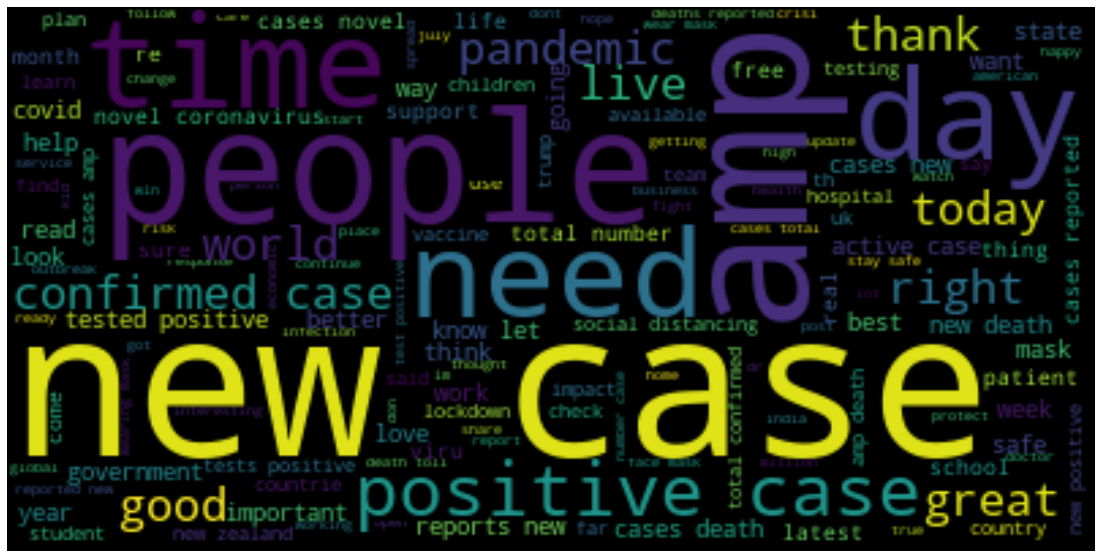

In [71]:
plot_wordcloud(pos_docx)

### Word cloud for negative words

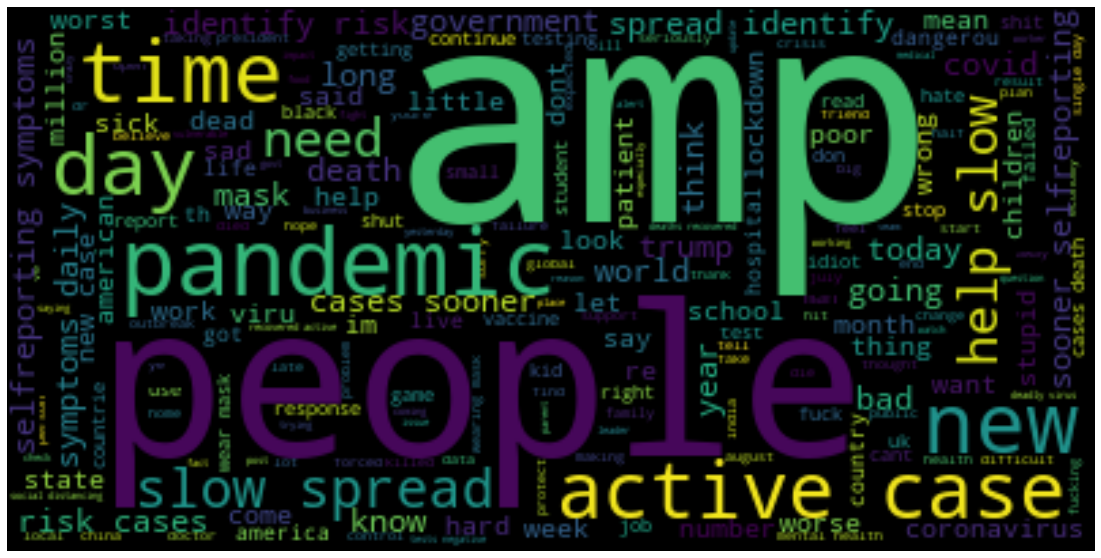

In [72]:
plot_wordcloud(neg_docx)

### Word cloud for neutral words

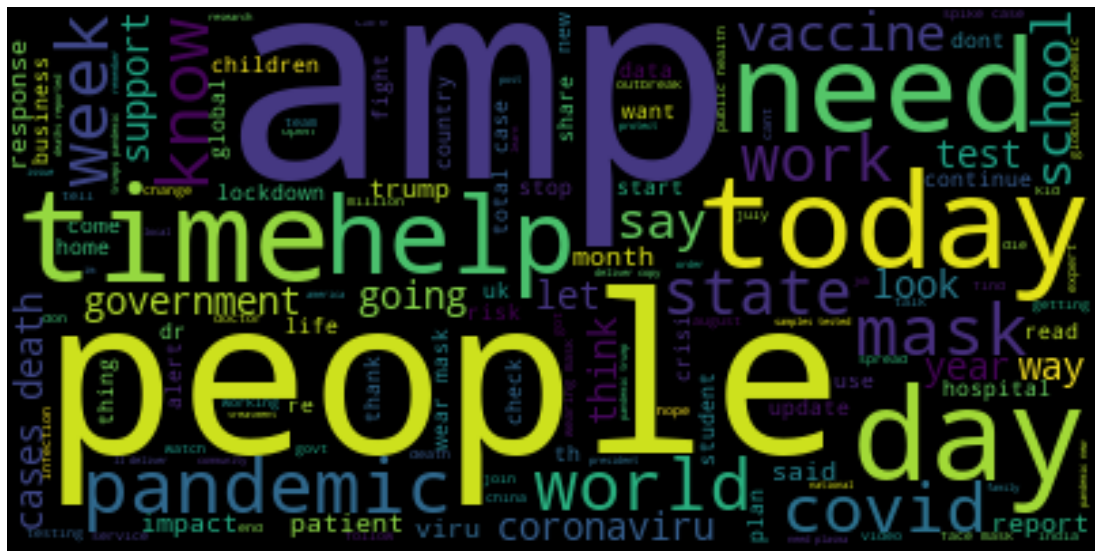

In [73]:
plot_wordcloud(neu_docx)